In [1]:
""" Installing libraries """
# %pip install pandas==2.3.2 matplotlib==3.10.6 seaborn==0.13.2 scikit-learn==1.7.1 numpy==2.2.6 pyarrow==21.0.0 torch==2.8.0
%pip install --quiet pandas==2.3.2 matplotlib==3.10.6 seaborn==0.13.2 scikit-learn==1.7.1 numpy==2.2.6 pyarrow==21.0.0 torch==2.8.0


Note: you may need to restart the kernel to use updated packages.


In [2]:
""" Importing libraries """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
""" Importing our modules """

from Modules.loading.read_parquet import read_parquet_file
from Modules.preprocessing.onehot import one_hot_encode_parquet
from Modules.preprocessing.removing_categorical_tables import get_numerical_table
from Modules.preprocessing.removing_outliers import remove_outliers_iqr


In [4]:
""" Setting up the constants """

DATA_PATH = "../Data/hackathon_2025_templates/part-00000-tid-"

FILE_HASH = [
    "2779033056155408584-f6316110-4c9a-4061-ae48-69b77c7c8c36", # LOJAS
    "5196563791502273604-c90d3a24-52f2-4955-b4ec-fb143aae74d8", # TRANSAÇÕES
    "7173294866425216458-eae53fbf-d19e-4130-ba74-78f96b9675f1", # PRODUTOS
]

SUFIX = "-4-1-c000.snappy.parquet"

FILE_NAMES = [DATA_PATH + hash + SUFIX for hash in FILE_HASH]


In [5]:
""" Loading the data """

# for file in FILE_NAMES:
loaded_data = {
    # "lojas": read_parquet_file(FILE_NAMES[0]),
    "transacoes": read_parquet_file(FILE_NAMES[1]),
    # "produtos": read_parquet_file(FILE_NAMES[2]),
}


In [6]:
numerical_table = get_numerical_table(loaded_data)

In [7]:
numerical_table

,internal_store_id,internal_product_id,transaction_date,quantity
0,7384367747233276219,328903483604537190,2022-07-13,1
1,3536908514005606262,5418855670645487653,2022-03-21,6
2,3138231730993449825,1087005562675741887,2022-09-06,3
3,3681167389484217654,1401422983880045188,2022-09-11,129
4,7762413312337359369,6614994347738381720,2022-02-18,1
...,...,...,...,...
6560693,1439579822593789678,2523145330235258825,2022-12-06,3
6560694,2357589266242432199,3148628429396585683,2022-05-20,1
6560695,7245187752757348055,6668439675743950745,2022-08-17,1
6560696,8952609383990245450,3894706280449257667,2022-02-03,4


In [33]:
pivoted_df = numerical_table.copy()

# 3) garantir que a data esteja no formato datetime
pivoted_df["transaction_date"] = pd.to_datetime(pivoted_df["transaction_date"])

# 4) pivotar: dia x par produto-loja
full_df = (
    pivoted_df.pivot_table(
        index="transaction_date",                        # agora usa transaction_date
        columns=["internal_product_id", "internal_store_id"],  
        values="quantity",                               # mantenha 'quantity' se esse for o nome certo
        aggfunc="sum",
        fill_value=0
    )
)

In [8]:
def l_single_remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Keep only rows within the bounds
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_clean

def l_remove_outliers_iqr(df, columns):
    for col in columns:
        df = l_single_remove_outlier_iqr(df, col)


def plot_graphs(df, column='quantity', title='', buckets=1000):
    # 2. Plot the distribution before removing outliers
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], bins=buckets, kde=True)
    plt.title(title)
    plt.show()

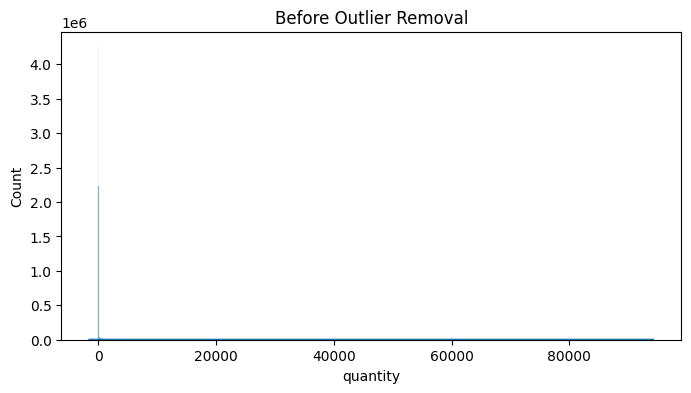

In [9]:
""" Cleaning the data """

cleaned_data = numerical_table.copy()

# 1. Sort the DataFrame by 'quantity'
df_sorted = cleaned_data.sort_values('quantity')
plot_graphs(df_sorted, 'quantity', 'Before Outlier Removal')


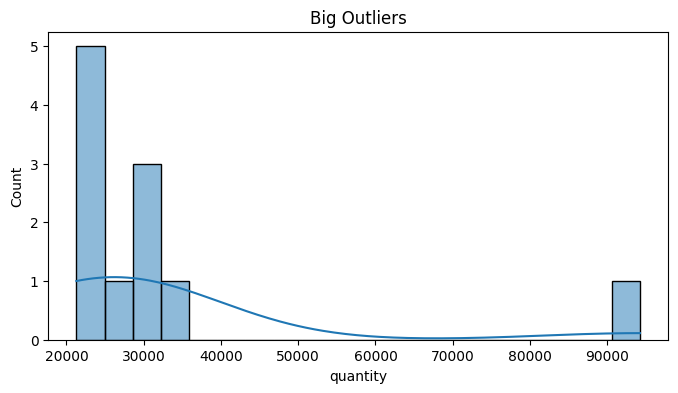

,internal_store_id,internal_product_id,transaction_date,quantity
162174,1340332798477535467,4132331673431899392,2022-09-11,24922
486280,6434414063399492998,7660365129551200715,2022-09-11,32424
644024,1365839146278641704,6608102981224815905,2022-09-11,94230
963774,6434414063399492998,3652281557572916499,2022-09-11,32070
1927546,3788165798747794145,7660365129551200715,2022-09-11,21744
1928998,4804165151893923520,3652281557572916499,2022-09-11,27252
2887028,3788165798747794145,3652281557572916499,2022-09-11,21288
2888332,5658815032567467999,3652281557572916499,2022-09-11,22354
3049296,4804165151893923520,7660365129551200715,2022-09-11,21648
4490770,5658815032567467999,7660365129551200715,2022-09-11,28820


In [10]:
# Select all values from the 'quantity' column that are greater than 20k
big_outliers = cleaned_data[cleaned_data['quantity'] >= 20000]
plot_graphs(big_outliers, 'quantity', 'Big Outliers', 20)
big_outliers

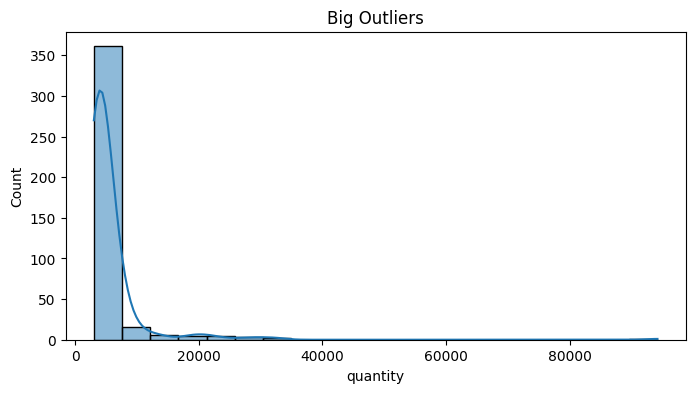

,internal_store_id,internal_product_id,transaction_date,quantity
1132,4882947442884300565,3620674245436818138,2022-09-11,3086
3959,6567641125465858007,6639182541769323770,2022-09-11,3525
6758,2720921832183866690,3620674245436818138,2022-09-11,6221
8441,8484980400903988433,379454763001947803,2022-09-11,3336
9881,9171644843739559005,3403023748159892753,2022-09-11,3964
...,...,...,...,...
6410055,7485443215246301632,1365813714550729758,2022-09-11,3024
6410806,539790426272889140,3620674245436818138,2022-09-11,4212
6412084,5322800571181846563,3654799619916051085,2022-09-11,6369
6412433,9171644843739559005,3212701144500706568,2022-09-11,3208


In [11]:
# Select all values from the 'quantity' column that are greater than 20k
bigger_outliers = cleaned_data[cleaned_data['quantity'] >= 3000]
plot_graphs(bigger_outliers, 'quantity', 'Big Outliers', 20)
bigger_outliers

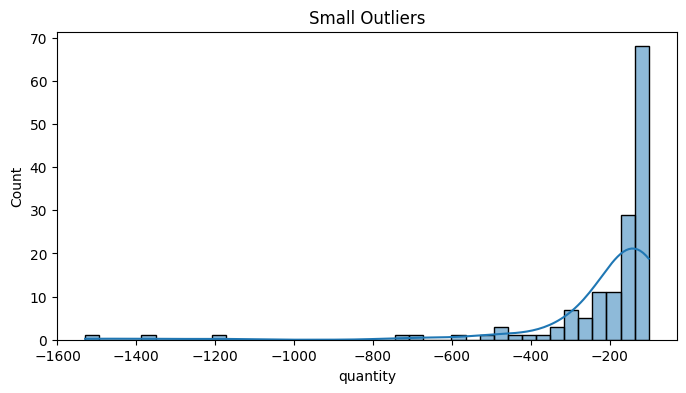

quantity
-120    25
-144    10
-216     4
-150     4
-131     3
        ..
-170     1
-234     1
-137     1
-289     1
-392     1
Name: count, Length: 83, dtype: int64

In [12]:
""" Small outliers """
small_outliers = cleaned_data[cleaned_data['quantity'] < -100]

plot_graphs(small_outliers, 'quantity', 'Small Outliers', 40)
# small_outliers

small_outliers['quantity'].value_counts()

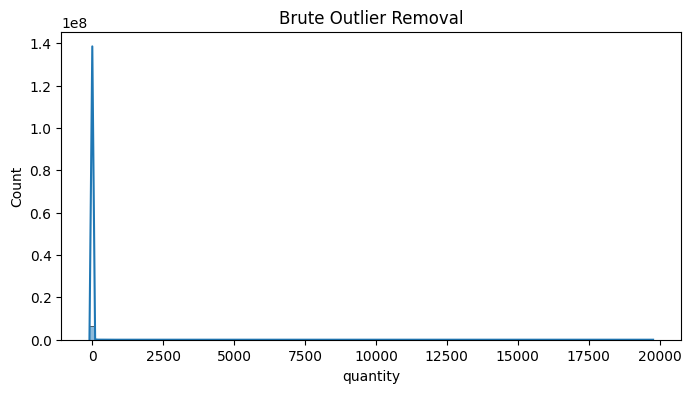

,internal_store_id,internal_product_id,transaction_date,quantity
0,7384367747233276219,328903483604537190,2022-07-13,1
1,3536908514005606262,5418855670645487653,2022-03-21,6
2,3138231730993449825,1087005562675741887,2022-09-06,3
3,3681167389484217654,1401422983880045188,2022-09-11,129
4,7762413312337359369,6614994347738381720,2022-02-18,1
...,...,...,...,...
6560693,1439579822593789678,2523145330235258825,2022-12-06,3
6560694,2357589266242432199,3148628429396585683,2022-05-20,1
6560695,7245187752757348055,6668439675743950745,2022-08-17,1
6560696,8952609383990245450,3894706280449257667,2022-02-03,4


In [13]:
# Get all values from -100 to 20k

brute_outlierless = cleaned_data[(cleaned_data['quantity'] > -100) & (cleaned_data['quantity'] < 20000)]
plot_graphs(brute_outlierless, 'quantity', 'Brute Outlier Removal', 100)
brute_outlierless

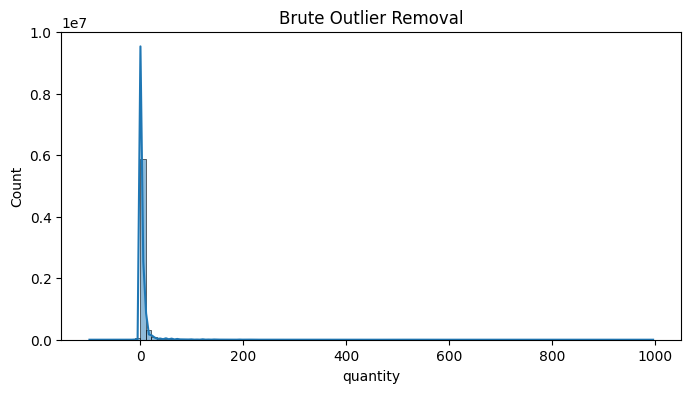

,internal_store_id,internal_product_id,transaction_date,quantity
0,7384367747233276219,328903483604537190,2022-07-13,1
1,3536908514005606262,5418855670645487653,2022-03-21,6
2,3138231730993449825,1087005562675741887,2022-09-06,3
3,3681167389484217654,1401422983880045188,2022-09-11,129
4,7762413312337359369,6614994347738381720,2022-02-18,1
...,...,...,...,...
6560693,1439579822593789678,2523145330235258825,2022-12-06,3
6560694,2357589266242432199,3148628429396585683,2022-05-20,1
6560695,7245187752757348055,6668439675743950745,2022-08-17,1
6560696,8952609383990245450,3894706280449257667,2022-02-03,4


In [14]:
# Get all values from -100 to 20k

bruter_outlierless = cleaned_data[(cleaned_data['quantity'] > -100) & (cleaned_data['quantity'] < 1000)]
plot_graphs(bruter_outlierless, 'quantity', 'Brute Outlier Removal', 100)
bruter_outlierless

lower_bound: -12.5 ; upper_bound: 23.5


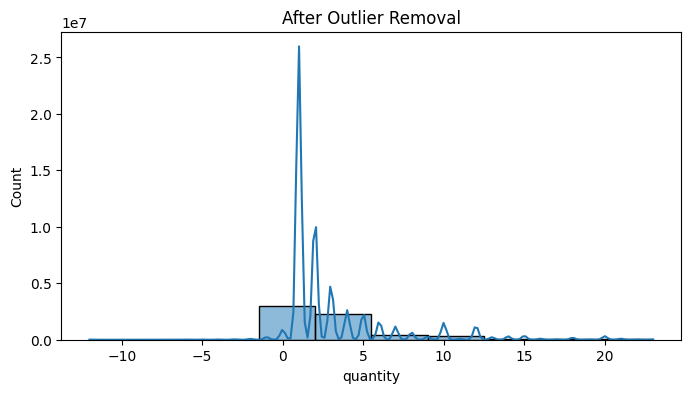

,internal_store_id,internal_product_id,transaction_date,quantity
4863893,916927572359668482,8649875144776229933,2022-06-06,-12
152135,8294871217390043140,2729570553257656610,2022-11-21,-12
4015086,1797309951298679721,8856119268328366400,2022-12-29,-12
4162231,88472223614755218,4424971686529367537,2022-02-02,-12
4163294,6653292867682231433,792466371771826966,2022-10-07,-12
...,...,...,...,...
4345893,6533382908843835688,1120490062981954254,2022-05-10,23
6154122,5553952637533339294,8275181357437864705,2022-11-03,23
2620501,2170229172447965480,1355221146658254593,2022-08-05,23
2435495,990571711439878263,1860061817666925715,2022-02-09,23


In [15]:

# 3. Remove outliers using IQR
Q1 = df_sorted['quantity'].quantile(0.1)
Q3 = df_sorted['quantity'].quantile(0.9)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
iqr_outlierless = df_sorted[(df_sorted['quantity'] >= lower_bound) & (df_sorted['quantity'] <= upper_bound)]

print('lower_bound:', lower_bound, '; upper_bound:', upper_bound)
plot_graphs(iqr_outlierless, 'quantity', 'After Outlier Removal', buckets=10)
iqr_outlierless

In [16]:
cleaned_data

,internal_store_id,internal_product_id,transaction_date,quantity
0,7384367747233276219,328903483604537190,2022-07-13,1
1,3536908514005606262,5418855670645487653,2022-03-21,6
2,3138231730993449825,1087005562675741887,2022-09-06,3
3,3681167389484217654,1401422983880045188,2022-09-11,129
4,7762413312337359369,6614994347738381720,2022-02-18,1
...,...,...,...,...
6560693,1439579822593789678,2523145330235258825,2022-12-06,3
6560694,2357589266242432199,3148628429396585683,2022-05-20,1
6560695,7245187752757348055,6668439675743950745,2022-08-17,1
6560696,8952609383990245450,3894706280449257667,2022-02-03,4


In [26]:

print('df_sorted:\t\t', df_sorted.shape[0], end='\t')
print('\tMin value:', df_sorted['quantity'].min(), '; Max value:', df_sorted['quantity'].max())

print('brute_outlierless:\t', brute_outlierless.shape[0], end='\t')
print('\tMin value:', brute_outlierless['quantity'].min(), '; Max value:', brute_outlierless['quantity'].max())

print('bruter_outlierless:\t', bruter_outlierless.shape[0], end='\t')
print('\tMin value:', bruter_outlierless['quantity'].min(), '; Max value:', bruter_outlierless['quantity'].max())

print('iqr_outlierless:\t', iqr_outlierless.shape[0], end='\t')
print('\tMin value:', iqr_outlierless['quantity'].min(), '; Max value:', iqr_outlierless['quantity'].max())

df_sorted:		 6560698		Min value: -1530 ; Max value: 94230
brute_outlierless:	 6560536		Min value: -99 ; Max value: 19773
bruter_outlierless:	 6556940		Min value: -99 ; Max value: 997
iqr_outlierless:	 6264460		Min value: -12 ; Max value: 23


In [ ]:
""" A more robust outlier treatment? """

def outlier_score(x, q1, q3, iqr):
    # Score de outlier (0 = normal, >0 = quão anômalo é)
    if iqr == 0:
        return 0.0
    if x < q1 - 1.5 * iqr:
        return (q1 - x) / iqr
    elif x > q3 + 1.5 * iqr:
        return (x - q3) / iqr
    else:
        return 0.0

def treat_outliers(group):
    q1 = group["quantity"].quantile(0.25)
    q3 = group["quantity"].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    group["is_outlier"] = group["quantity"].apply(lambda x: outlier_score(x, q1, q3, iqr))
    
    # média dos não-outliers
    mean_non_outliers = group.loc[group["is_outlier"] == 0, "quantity"].mean()
    
    # substitui outliers (se houver)
    if not pd.isna(mean_non_outliers):
        group.loc[group["is_outlier"] > 0, "quantity"] = mean_non_outliers
    
    return group

outlier_per_group = numerical_table.copy()

outlier_per_group["quantity"] = outlier_per_group["quantity"].astype(float) # Ensure 'quantity' is float for calculations

# group data by 'internal_store_id' and 'internal_product_id'
outlier_removal = outlier_per_group.groupby(["internal_store_id", "internal_product_id"], group_keys=False)
# CÉLULA 9
outlier_removal